In [1]:
# !pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
assets = ['SPY', 'QQQ', 'IWM', 'EFA', 'EEM', 'TLT', 'LQD', 'GLD', 'XLE', 'XLV']
df = yf.download(assets, start='2010-01-01', end='2025-07-27')['Close'].dropna()
returns = df.pct_change().dropna()
returns.to_csv(r'C:/Users/Navin/Desktop/Finance Final/quant_finance_pipeline/data/price.csv', index=None)

C:\Users\Navin\AppData\Local\Temp\ipykernel_2824\984287450.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(assets, start='2010-01-01', end='2025-07-27')['Close'].dropna()
[*********************100%***********************]  10 of 10 completed


In [3]:
returns.head()

Ticker,EEM,EFA,GLD,IWM,LQD,QQQ,SPY,TLT,XLE,XLV
Date,,,,,,,,,,
2010-01-05,0.007258,0.000881,-0.000911,-0.003439,0.004776,0.000000,0.002647,0.006457,0.008161,-0.009807
2010-01-06,0.002092,0.004227,0.016500,-0.000941,-0.002947,-0.006032,0.000704,-0.013386,0.011975,0.010224
2010-01-07,-0.005800,-0.003858,-0.006188,0.007378,0.001239,0.000650,0.004221,0.001682,-0.001500,0.003478
2010-01-08,0.007933,0.007922,0.004963,0.005454,0.002190,0.008231,0.003328,-0.000448,0.006510,0.001576
2010-01-11,-0.002083,0.008209,0.013289,-0.004030,0.001045,-0.004082,0.001396,-0.005488,-0.001327,0.005664


In [4]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled = scaler.fit_transform(returns)

In [5]:
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X,y = create_sequences(returns.values)

In [6]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff = tf.keras.Sequential([
        Dense(ff_dim, activation="relu"),
        Dropout(dropout),
        Dense(inputs.shape[-1]),
    ])
    x = ff(x)
    return Add()([x, inputs])

In [37]:
def build_model(hp):
    inputs = Input(shape=(window, X_train.shape[2]))
    
    # LSTM Layer
    lstm_units = hp.Int("lstm_units", min_value=64, max_value=128, step=64)
    x = LSTM(units=lstm_units, return_sequences=True)(inputs)
    x = Dropout(hp.Float("lstm_dropout", 0.1, 0.5, step=0.1))(x)
    
    # Transformer Block
    x = transformer_block(
        x,
        head_size=hp.Choice("head_size", [128,256,512]),
        num_heads=hp.Choice("num_heads", [ 16,32]),
        ff_dim=hp.Choice("ff_dim", [32, 64,96]),
        dropout=hp.Float("trans_dropout", 0.1, 0.5, step=0.1)
    )
    
    # Final layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(hp.Int("dense_units", 32, 128, step=32), activation='relu')(x)
    x = Dropout(hp.Float("final_dropout", 0.1, 0.5, step=0.1))(x)
    outputs = Dense(X_train.shape[2], activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [38]:
from keras_tuner.tuners import RandomSearch
window=30
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=95,
    executions_per_trial=1,
    directory=r'C:/Users/Navin/Desktop/Finance Final/quant_finance_pipeline/data/keras_tuner_logs',
    project_name='hybrid_model_tuning'
)


In [ ]:
tuner.search(X_train, y_train, validation_split=0.2, epochs=35, batch_size=64, callbacks=[EarlyStopping(patience=3)])


best_model = tuner.get_best_models(num_models=1)[0]


y_pred = best_model.predict(X_test)

Trial 8 Complete [00h 16m 57s]
val_loss: 0.0002841443056240678

Best val_loss So Far: 0.0002841443056240678
Total elapsed time: 01h 37m 39s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
128               |128               |lstm_units
0.1               |0.5               |lstm_dropout
512               |256               |head_size
32                |32                |num_heads
32                |64                |ff_dim
0.5               |0.3               |trans_dropout
32                |128               |dense_units
0.5               |0.1               |final_dropout

Epoch 1/35
39/39 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - loss: 0.5041 - val_loss: 3.2625e-04
Epoch 2/35
39/39 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - loss: 1.3277e-04 - val_loss: 3.0186e-04
Epoch 3/35
39/39 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - loss: 1.2084e-04 - val_loss: 2.9555e-04
Epoch 4/35
39/39 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - loss: 1.1780e-04 - val_loss: 2.9261e-04
Epoch 5/35
39/39

KeyboardInterrupt: 

In [43]:
best_model = tuner.get_best_models(num_models=1)[0]


y_pred = best_model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 278ms/step


In [44]:
def compute_metrics(y_true, y_pred):
    portfolio_return = np.sum(y_pred * y_true, axis=1)
    ann_return = np.mean(portfolio_return) * 252
    ann_vol = np.std(portfolio_return) * np.sqrt(252)
    sharpe = ann_return / ann_vol
    max_dd = np.min(portfolio_return.cumsum() - np.maximum.accumulate(portfolio_return.cumsum()))
    return ann_return, ann_vol, sharpe, max_dd

In [45]:
ann_return, ann_vol, sharpe, max_dd = compute_metrics(y_test, y_pred)
print(f"Annualized Return: {ann_return:.2%}")
print(f"Annualized Volatility: {ann_vol:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2%}")

Annualized Return: 0.06%
Annualized Volatility: 0.06%
Sharpe Ratio: 0.97
Max Drawdown: -0.07%


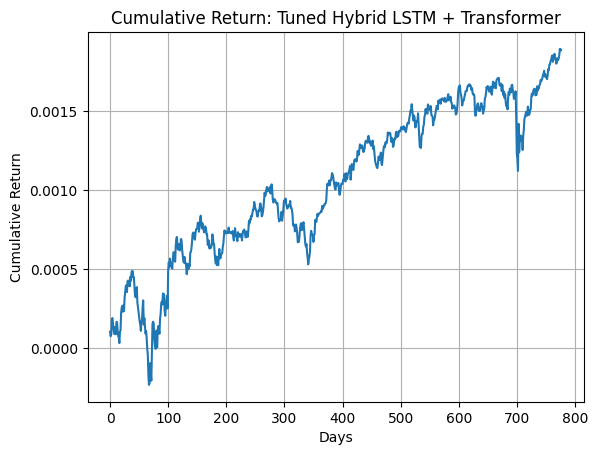

In [46]:
portfolio_returns = np.sum(y_pred * y_test, axis=1)
cumulative_returns = np.cumsum(portfolio_returns)
plt.plot(cumulative_returns)
plt.title("Cumulative Return: Tuned Hybrid LSTM + Transformer")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [47]:
best_model.save(r'C:/Users/Navin/Desktop/Finance Final/quant_finance_pipeline/models/hybrid_lstm_transformer_model.h5')

In [49]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)    
# r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")     


Mean Squared Error: 0.0001
